<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C4/blob/main/W3/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Question Answering
Welcome to this week's assignment of course 4. In this you will explore question answering. You will implement the "Text to Text Transfer from Transformers" (better known as T5). Since you implemented transformers from scratch last week you will now be able to use them.



## Overview
This assignment will be different from the two previous ones. Due to memory and time constraints of this environment you will not be able to train a model and use it for inference. Instead you will create the necessary building blocks for the transformer encoder model and will use a pretrained version of the same model in two ungraded labs after this assignment.

After completing these 3 (1 graded and 2 ungraded) labs you will:

Implement the code neccesary for Bidirectional Encoder Representation from Transformer (BERT).
Understand how the C4 dataset is structured.
Use a pretrained model for inference.
Understand how the "Text to Text Transfer from Transformers" or T5 model works.

Overview
This assignment will be different from the two previous ones. Due to memory and time constraints of this environment you will not be able to train a model and use it for inference. Instead you will create the necessary building blocks for the transformer encoder model and will use a pretrained version of the same model in two ungraded labs after this assignment.

After completing these 3 (1 graded and 2 ungraded) labs you will:

* Implement the code neccesary for Bidirectional Encoder Representation from Transformer (BERT).
* Understand how the C4 dataset is structured.
* Use a pretrained model for inference.
* Understand how the "Text to Text Transfer from Transformers" or T5 model works.

In [1]:
import ast
import string
import textwrap
import itertools
import numpy as np

!pip install trax

import trax 
from trax import layers as tl
from trax.supervised import decoding

# Will come handy later.
wrapper = textwrap.TextWrapper(width=70)

# Set random seed
np.random.seed(42)

     |████████████████████████████████| 522kB 5.8MB/s 
     |████████████████████████████████| 215kB 44.1MB/s 
     |████████████████████████████████| 3.4MB 49.2MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 3.8MB 44.9MB/s 
     |████████████████████████████████| 1.2MB 41.1MB/s 
     |████████████████████████████████| 1.9MB 49.9MB/s 
     |████████████████████████████████| 368kB 34.8MB/s 
     |████████████████████████████████| 3.2MB 40.9MB/s 
     |████████████████████████████████| 890kB 43.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=af75509c76f93e06c8e6f43e0f06d8252d20ada7a68fcfbe767f5d17aecf1ef6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!git clone https://github.com/DrAlexSanz/NLP-SPEC-C4.git

!mv "NLP-SPEC-C4/W3/data.txt" "./"
!mv "NLP-SPEC-C4/W3/example.txt" "./"
!mv "NLP-SPEC-C4/W3/example_bpe.model" "./"
!mv "NLP-SPEC-C4/W3/example_bpe.vocab" "./"
!mv "NLP-SPEC-C4/W3/inputs_targets_pairs_file.txt" "./"
!mv "NLP-SPEC-C4/W3/sentencepiece.model" "./"
!mv "NLP-SPEC-C4/W3/summarize32k.subword.subwords" "./"
!rm -rf "NLP-SPEC-C4"

Cloning into 'NLP-SPEC-C4'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 121 (delta 32), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (121/121), 2.41 MiB | 5.58 MiB/s, done.
Resolving deltas: 100% (32/32), done.


# Part 1: C4 Dataset
The C4 is a huge data set. For the purpose of this assignment you will use a few examples out of it which are present in data.txt. C4 is based on the common crawl project. Feel free to read more on their website.

In [3]:
example_jsons = list(map(ast.literal_eval, open("data.txt")))

for i in range(5):
    print(f"Example number {i}: \n\n {example_jsons[i]} \n")

Example number 0: 

 {'content-length': b'1970', 'content-type': b'text/plain', 'text': b'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': b'2019-04-25T12:57:54Z', 'url': b'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'} 

Example number 1: 

 {'content-length': b'1

Notice the b before each string? This means that this data comes as bytes rather than strings. Strings are actually lists of bytes so for the rest of the assignments the name strings will be used to describe the data.

In [4]:
print(type(example_jsons[0].get("text"))) #this is a "bytes"
print(type(example_jsons[0])) # This is a dict
print(type(example_jsons)) # And this is a list because I forced it (list of dicts).

<class 'bytes'>
<class 'dict'>
<class 'list'>


## 1.1 Pre-Training Objective
Note: The word "mask" will be used throughout this assignment in context of hiding/removing word(s)

You will be implementing the BERT loss as shown in the following image.

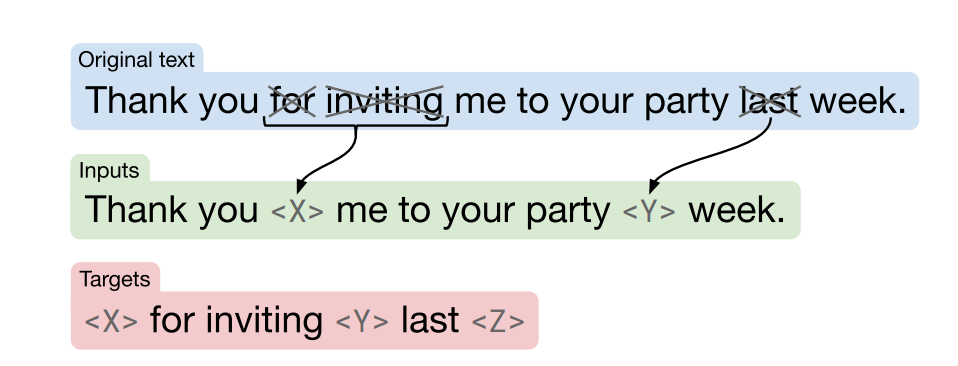

Assume you have the following text: **Thank you for inviting me to your party last week** 

Now as input you will mask the words in red in the text:

**Input:** Thank you X me to your party Y week.

**Output:** The model should predict the words(s) for X and Y.

Z is used to represent the end.

## 1.2 Process C4
C4 only has the plain string text field, so you will tokenize and have inputs and targets out of it for supervised learning. Given your inputs, the goal is to predict the targets during training.

You will now take the text and convert it to inputs and targets.

In [5]:
# Take the text field from the dict:

natural_language_texts = [example_json["text"] for example_json in example_jsons]

In [6]:
natural_language_texts[4]

b'The Denver Board of Education opened the 2017-18 school year with an update on projects that include new construction, upgrades, heat mitigation and quality learning environments.\nWe are excited that Denver students will be the beneficiaries of a four year, $572 million General Obligation Bond. Since the passage of the bond, our construction team has worked to schedule the projects over the four-year term of the bond.\nDenver voters on Tuesday approved bond and mill funding measures for students in Denver Public Schools, agreeing to invest $572 million in bond funding to build and improve schools and $56.6 million in operating dollars to support proven initiatives, such as early literacy.\nDenver voters say yes to bond and mill levy funding support for DPS students and schools. Click to learn more about the details of the voter-approved bond measure.\nDenver voters on Nov. 8 approved bond and mill funding measures for DPS students and schools. Learn more about what\xe2\x80\x99s incl

## 1.2.1 Decode to natural language
The following functions will help you detokenize andtokenize the text data.

The sentencepiece vocabulary was used to convert from text to ids. This vocabulary file is loaded and used in this helper functions.

natural_language_texts has the text from the examples we gave you.

In [7]:
PAD = 0
EOS = 1
UNK = 2

def detokenize(np_array):
    detok = trax.data.detokenize(np_array, vocab_type = "sentencepiece", vocab_file = "sentencepiece.model", vocab_dir = ".")
    return detok


def tokenize(a_string):
    tokens = trax.data.tokenize(iter([a_string]), vocab_type = "sentencepiece", vocab_file = "sentencepiece.model", vocab_dir = ".")
    return next(tokens)



In [8]:
# Test

tokenized_text = [(tokenize(word).tolist(), word) for word in natural_language_texts[0].split()]

print(tokenized_text, "\n")

[([12847, 277], b'Beginners'), ([15068], b'BBQ'), ([4501], b'Class'), ([3, 12297], b'Taking'), ([3399], b'Place'), ([16], b'in'), ([5964, 7115, 9, 55], b'Missoula!'), ([531], b'Do'), ([25], b'you'), ([241], b'want'), ([12], b'to'), ([129], b'get'), ([394], b'better'), ([44], b'at'), ([492], b'making'), ([3326], b'delicious'), ([15068, 58], b'BBQ?'), ([148], b'You'), ([56], b'will'), ([43], b'have'), ([8], b'the'), ([1004, 6], b'opportunity,'), ([474], b'put'), ([48], b'this'), ([30], b'on'), ([39], b'your'), ([4793], b'calendar'), ([230, 5], b'now.'), ([2721, 6], b'Thursday,'), ([1600], b'September'), ([1630, 727], b'22nd'), ([1715], b'join'), ([1150], b'World'), ([4501], b'Class'), ([15068], b'BBQ'), ([16127, 6], b'Champion,'), ([9137], b'Tony'), ([2659, 5595], b'Balay'), ([45], b'from'), ([301, 782, 3624], b'Lonestar'), ([14627, 15], b'Smoke'), ([12612, 277, 5], b'Rangers.'), ([216], b'He'), ([56], b'will'), ([36], b'be'), ([2119], b'teaching'), ([3, 9], b'a'), ([19529], b'beginner')

In [9]:
print(f"tokenized: {tokenize('Beginners')}\ndetokenized: {detokenize(tokenize('Beginners'))}")

tokenized: [12847   277]
detokenized: Beginners


Now you will create input and target pairs that will allow you to train your model. T5 uses the ids at the end of the vocab file as sentinels. For example, it will replace:

  * vocab_size - 1 by < Z >
  *vocab_size - 2 by < Y >

and so forth.
It assigns every word a chr.

The pretty_decode function below, which you will use in a bit, helps in handling the type when decoding. Take a look and try to understand what the function is doing.

**Notice that:**

string.ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

**NOTE:** Targets may have more than the 52 sentinels we replace, but this is just to give you an idea of things.

In [14]:
vocab_size = trax.data.vocab_size(vocab_type = "sentencepiece", vocab_file = "sentencepiece.model", vocab_dir = ".")

def get_sentinels(vocab_size = vocab_size, display = False):

    sentinels = {}

    for i, char in enumerate(reversed(string.ascii_letters), 1):
        decoded_text = detokenize([vocab_size - i])

        sentinels[decoded_text] = f"<{char}>"

        if display:
            print(f"The sentinel is <{char}> and the decoded token is {decoded_text}")

    return sentinels

In [16]:
sentinels = get_sentinels(vocab_size = vocab_size, display = True)

The sentinel is <Z> and the decoded token is Internațional
The sentinel is <Y> and the decoded token is erwachsene
The sentinel is <X> and the decoded token is Cushion
The sentinel is <W> and the decoded token is imunitar
The sentinel is <V> and the decoded token is Intellectual
The sentinel is <U> and the decoded token is traditi
The sentinel is <T> and the decoded token is disguise
The sentinel is <S> and the decoded token is exerce
The sentinel is <R> and the decoded token is nourishe
The sentinel is <Q> and the decoded token is predominant
The sentinel is <P> and the decoded token is amitié
The sentinel is <O> and the decoded token is erkennt
The sentinel is <N> and the decoded token is dimension
The sentinel is <M> and the decoded token is inférieur
The sentinel is <L> and the decoded token is refugi
The sentinel is <K> and the decoded token is cheddar
The sentinel is <J> and the decoded token is unterlieg
The sentinel is <I> and the decoded token is garanteaz
The sentinel is <H> 

In [29]:
def pretty_decode(encoded_str_list, sentinels=sentinels):
    # If already a string, just do the replacements.
    if isinstance(encoded_str_list, (str, bytes)):
        for token, char in sentinels.items():
            encoded_str_list = encoded_str_list.replace(token, char)
        return encoded_str_list
  
    # We need to decode and then prettyfy it.
    return pretty_decode(detokenize(encoded_str_list))

    

In [30]:
pretty_decode("I want to dress up as an Intellectual this halloween.")

'I want to dress up as an <V> this <b>.'

The functions above make your inputs and targets more readable. For example, you might see something like this once you implement the masking function below.

* Input sentence: Younes and Lukasz were working together in the lab yesterday after lunch.
* Input: Younes and Lukasz Z together in the Y yesterday after lunch.
* Target: Z were working Y lab.

## 1.3 Tokenizing and Masking
You will now implement the tokenize_and_mask function. This function will allow you to tokenize and mask input words with a noise probability. We usually mask 15% of the words.